In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import shift
from darts import TimeSeries
from darts.models import XGBModel, LinearRegressionModel, CatBoostModel
from tqdm import tqdm
import pdb

In [2]:
data = pd.read_csv(
    './deaths.csv'
)[['ahead', 'forecaster', 'geo_value', 'target_end_date', 'forecast_0.1', 'forecast_0.5', 'forecast_0.9', 'actual']]
populations = pd.read_csv('./state_populations.csv')
populations = { populations.State[j] : populations.Population[j] for j in range(len(populations))}
weeks_ahead = 4
data = data[(data.ahead == weeks_ahead) & (data.forecaster == 'COVIDhub-4_week_ensemble') & (data.geo_value != 'us') & (data.geo_value != 'mp') & (data.geo_value != 'pr') & (data.geo_value != 'vi') & (data.geo_value != 'as') & (data.geo_value != 'gu')].reset_index(drop=True).drop(['ahead', 'forecaster'], axis=1).dropna().sort_values('target_end_date')
data.target_end_date = pd.to_datetime(data.target_end_date)
states = np.unique(data.geo_value)
dates = np.unique(data.target_end_date); dates.sort()
data['population'] = [int(populations[st]) for st in data.geo_value]
data['scores_upper'] = (data['actual'] - data['forecast_0.9'])/data['population']
data['scores_lower'] = (data['forecast_0.1'] - data['actual'])/data['population']
print(len(data))
data.head()

7191


,geo_value,target_end_date,forecast_0.1,forecast_0.5,forecast_0.9,actual,population,scores_upper,scores_lower
0,dc,2020-07-04,4.165558,12.25822,28.38031,9.0,689545,-0.000028,-7.011061e-06
28,nd,2020-07-04,7.159244,13.89417,25.09545,2.0,779094,-0.000030,6.622107e-06
29,ok,2020-07-04,9.347893,18.17246,38.97676,14.0,3959353,-0.000006,-1.174966e-06
30,or,2020-07-04,5.764261,17.86254,53.43991,11.0,4237256,-0.000010,-1.235644e-06
31,pa,2020-07-04,154.209600,263.51450,445.28880,144.0,13002700,-0.000023,7.851908e-07


In [4]:
scorecasts_upper = np.zeros((len(data),))
for state in tqdm(states):
    geo_idx = data.geo_value == state
    ts_scores_upper = TimeSeries.from_dataframe(data[geo_idx], time_col='target_end_date', value_cols='scores_upper')
    ts_covariates = TimeSeries.from_group_dataframe(data, group_cols='geo_value', time_col='target_end_date', value_cols=['scores_upper', 'scores_lower', 'actual'])
    model_upper = LinearRegressionModel(lags=[-3, -4, -5], lags_past_covariates=[-3, -4, -5])#, likelihood='quantile', quantiles=[0.1, 0.5, 0.90])

    # Perform the backtesting
    backtests = model_upper.historical_forecasts(ts_scores_upper, past_covariates=ts_covariates)#historical_forecasts(ts_scores_upper, num_samples=50).quantile(0.9)
    scorecasts_upper[geo_idx.to_numpy().squeeze()] = np.concatenate([np.zeros((geo_idx.sum() - len(backtests),)), backtests.values().squeeze()], axis=0)

100%|███████████████████████████████████████████████████████████████████████████| 51/51 [00:32<00:00,  1.56it/s]


In [5]:
data['scorecasts_upper'] = scorecasts_upper

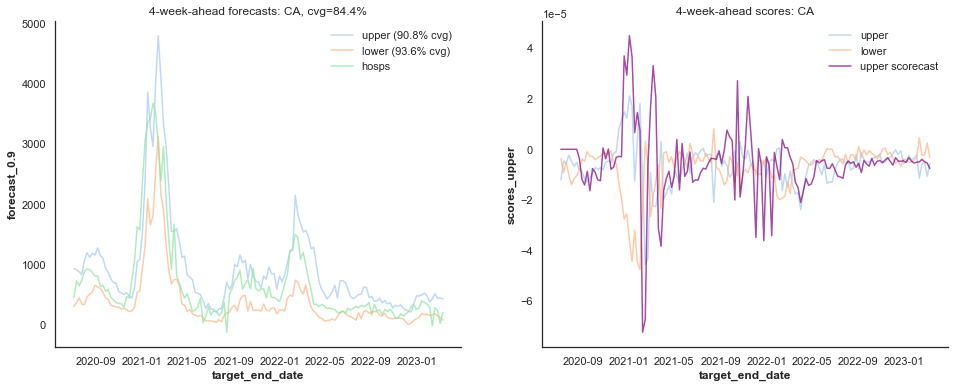

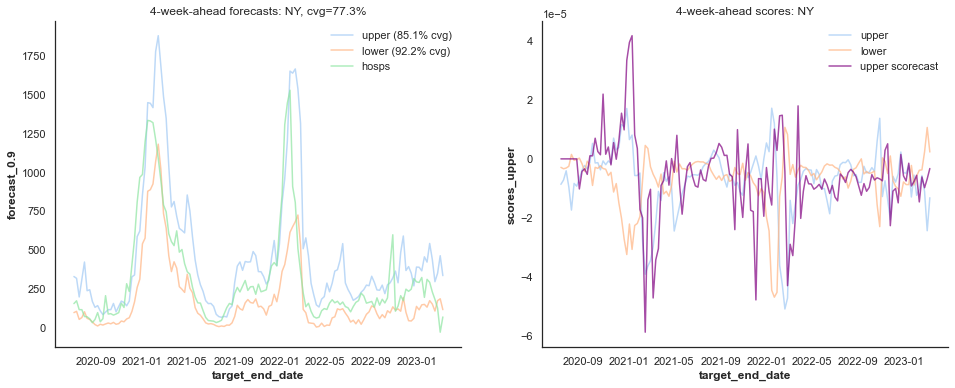

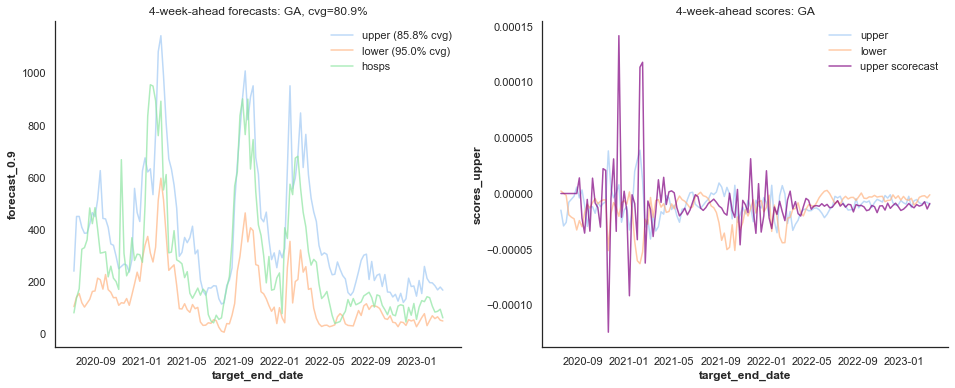

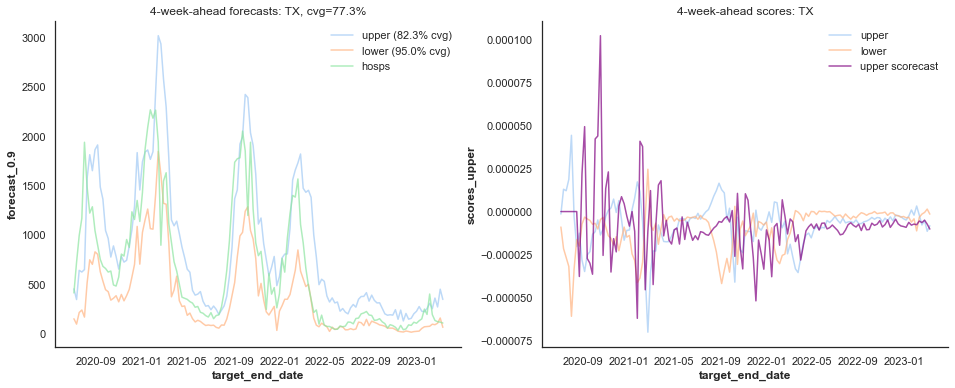

In [6]:
sns.set(palette='pastel', style='white')
for geo in ['ca', 'ny', 'ga', 'tx']:
    data_geo = data[data.geo_value == geo]
    cvg_upper = (data_geo['scores_upper'] <= 0).mean()
    cvg_lower = (data_geo['scores_lower'] <= 0).mean()
    cvg_total = ((data_geo['scores_lower'] <= 0) & (data_geo['scores_upper'] <= 0)).mean()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    sns.lineplot(data=data_geo, x='target_end_date', y='forecast_0.9', label=f"upper ({cvg_upper * 100 :.1f}% cvg)", errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='forecast_0.1', label=f"lower ({cvg_lower * 100 :.1f}% cvg)", errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='actual', label='hosps', errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scores_upper', label='upper', errorbar=None, ax=axs[1], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scores_lower', label='lower', errorbar=None, ax=axs[1], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scorecasts_upper', label='upper scorecast', errorbar=None, ax=axs[1], alpha=0.7, color='purple')
    sns.despine(top=True, right=True)
    axs[0].set_title(f"{weeks_ahead}-week-ahead forecasts: {geo.upper()}, cvg={cvg_total * 100 :.1f}%")
    axs[1].set_title(f"{weeks_ahead}-week-ahead scores: {geo.upper()}")